In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')


In [2]:
# =============================================================================
# DATA PREPARATION FOR OLS REGRESSION
# =============================================================================
# Define predictors and target
predictors = [
    'environmentsatisfaction', 'jobinvolvement', 'overtime', 
    'worklifebalance', 'trainingtimeslastyear', 'yearssincelastpromotion',
    'yearsincurrentrole', 'yearswithcurrmanager', 'percentsalaryhike', 
    'distancefromhome'
]

target = 'jobsatisfaction'

In [4]:
# Load your dataset (replace with your actual data loading)
dataset = pd.read_csv('ibm_hr_cleaned.csv', index_col=False)
dataset.shape # > 1470 x 32

(1470, 32)

In [13]:
# Prepare X and y
X = dataset[predictors]
y = dataset[target]

print(f"Dataset shape: {X.shape}")
print(f"Target variable: {target}")


Dataset shape: (1470, 10)
Target variable: jobsatisfaction


In [14]:
# =============================================================================
# PREPROCESSING FOR MULTICLASS CLASSIFICATION
# =============================================================================

# Convert categorical variables to dummy variables
X_processed = X.copy()

# Identify categorical predictors
categorical_predictors = []
numeric_predictors = []

for predictor in predictors:
    if X_processed[predictor].dtype == 'object' or X_processed[predictor].nunique() <= 5:
        categorical_predictors.append(predictor)
    else:
        numeric_predictors.append(predictor)

print(f"\nCategorical predictors: {categorical_predictors}")
print(f"Numeric predictors: {numeric_predictors}")

# Create dummy variables for categorical predictors
if categorical_predictors:
    X_processed = pd.get_dummies(X_processed, columns=categorical_predictors, drop_first=True)

# Handle missing values
X_processed = X_processed.fillna(X_processed.mean())
y = y.fillna(y.mode()[0] if len(y.mode()) > 0 else y.mean())

print(f"Processed features shape: {X_processed.shape}")


Categorical predictors: ['environmentsatisfaction', 'jobinvolvement', 'overtime', 'worklifebalance']
Numeric predictors: ['trainingtimeslastyear', 'yearssincelastpromotion', 'yearsincurrentrole', 'yearswithcurrmanager', 'percentsalaryhike', 'distancefromhome']
Processed features shape: (1470, 16)


In [17]:
# =============================================================================
# TRAIN-TEST SPLIT
# =============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts().sort_index()}")

# Scale numeric features for better model performance
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if numeric_predictors:
    # Scale only the numeric columns that remain after dummy encoding
    numeric_cols_remaining = [col for col in numeric_predictors if col in X_train.columns]
    if numeric_cols_remaining:
        X_train_scaled[numeric_cols_remaining] = scaler.fit_transform(X_train[numeric_cols_remaining])
        X_test_scaled[numeric_cols_remaining] = scaler.transform(X_test[numeric_cols_remaining])


Training set: (1029, 16)
Testing set: (441, 16)
Training target distribution:
jobsatisfaction
1    202
2    196
3    310
4    321
Name: count, dtype: int64


In [18]:
# =============================================================================
# APPROACH 1: MULTINOMIAL LOGISTIC REGRESSION
# =============================================================================

print("\n" + "="*60)
print("APPROACH 1: MULTINOMIAL LOGISTIC REGRESSION")
print("="*60)

# Multinomial Logistic Regression for multiclass classification
multinomial_lr = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

multinomial_lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_multinomial = multinomial_lr.predict(X_test_scaled)
y_pred_proba_multinomial = multinomial_lr.predict_proba(X_test_scaled)

# Evaluation
accuracy_multinomial = accuracy_score(y_test, y_pred_multinomial)

print(f"Multinomial Logistic Regression Accuracy: {accuracy_multinomial:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_multinomial))



APPROACH 1: MULTINOMIAL LOGISTIC REGRESSION
Multinomial Logistic Regression Accuracy: 0.3039

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        87
           2       0.25      0.04      0.06        84
           3       0.31      0.45      0.36       132
           4       0.31      0.52      0.39       138

    accuracy                           0.30       441
   macro avg       0.22      0.25      0.20       441
weighted avg       0.24      0.30      0.24       441



In [19]:

# =============================================================================
# APPROACH 2: RANDOM FOREST (NON-LINEAR RELATIONSHIPS)
# =============================================================================

print("\n" + "="*60)
print("APPROACH 2: RANDOM FOREST CLASSIFIER")
print("="*60)

rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_classifier.fit(X_train, y_train)  # No scaling needed for Random Forest

# Predictions
y_pred_rf = rf_classifier.predict(X_test)
y_pred_proba_rf = rf_classifier.predict_proba(X_test)

# Evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


APPROACH 2: RANDOM FOREST CLASSIFIER
Random Forest Accuracy: 0.2789

Classification Report:
              precision    recall  f1-score   support

           1       0.17      0.03      0.06        87
           2       0.15      0.05      0.07        84
           3       0.28      0.40      0.33       132
           4       0.30      0.46      0.36       138

    accuracy                           0.28       441
   macro avg       0.23      0.24      0.21       441
weighted avg       0.24      0.28      0.24       441



In [20]:
# =============================================================================
# APPROACH 3: ORDINAL LOGISTIC REGRESSION (IF SATISFACTION IS ORDINAL)
# =============================================================================

print("\n" + "="*60)
print("APPROACH 3: ORDINAL LOGISTIC REGRESSION")
print("="*60)

try:
    from sklearn.linear_model import LogisticRegression
    # Use one-vs-rest for ordinal classification
    ordinal_lr = LogisticRegression(
        multi_class='ovr',  # One-vs-Rest
        solver='liblinear',
        max_iter=1000,
        random_state=42
    )
    
    ordinal_lr.fit(X_train_scaled, y_train)
    y_pred_ordinal = ordinal_lr.predict(X_test_scaled)
    accuracy_ordinal = accuracy_score(y_test, y_pred_ordinal)
    
    print(f"Ordinal Logistic Regression (OvR) Accuracy: {accuracy_ordinal:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_ordinal))
    
except Exception as e:
    print(f"Ordinal logistic regression failed: {e}")



APPROACH 3: ORDINAL LOGISTIC REGRESSION
Ordinal Logistic Regression (OvR) Accuracy: 0.2993

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        87
           2       0.11      0.01      0.02        84
           3       0.30      0.45      0.36       132
           4       0.31      0.52      0.39       138

    accuracy                           0.30       441
   macro avg       0.18      0.25      0.19       441
weighted avg       0.21      0.30      0.23       441



In [22]:
# =============================================================================
# MODEL COMPARISON
# =============================================================================

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

models_comparison = pd.DataFrame({
    'Model': ['Multinomial Logistic Regression', 'Random Forest', 'Ordinal Logistic Regression (OvR)'],
    'Accuracy': [accuracy_multinomial, accuracy_rf, accuracy_ordinal]
})

print(models_comparison.sort_values('Accuracy', ascending=False))

# =============================================================================
# DETAILED ANALYSIS OF BEST MODEL
# =============================================================================

# Identify best model
best_model_name = models_comparison.loc[models_comparison['Accuracy'].idxmax(), 'Model']
print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")

if best_model_name == 'Multinomial Logistic Regression':
    best_model = multinomial_lr
    y_pred_best = y_pred_multinomial
    y_proba_best = y_pred_proba_multinomial
elif best_model_name == 'Random Forest':
    best_model = rf_classifier
    y_pred_best = y_pred_rf
    y_proba_best = y_pred_proba_rf
else:
    best_model = ordinal_lr
    y_pred_best = y_pred_ordinal
    y_proba_best = ordinal_lr.predict_proba(X_test_scaled)


MODEL COMPARISON SUMMARY
                               Model  Accuracy
0    Multinomial Logistic Regression  0.303855
2  Ordinal Logistic Regression (OvR)  0.299320
1                      Random Forest  0.278912

🏆 BEST PERFORMING MODEL: Multinomial Logistic Regression


In [ ]:
# Get the coefficient of multinomial logistic regression


MULTINOMIAL LOGISTIC REGRESSION COEFFICIENTS
Coefficients for each class (rows = classes, columns = features):
         trainingtimeslastyear  yearssincelastpromotion  yearsincurrentrole  \
Class_1               0.022421                 0.035395           -0.071751   
Class_2               0.028845                 0.044813           -0.013174   
Class_3              -0.061270                -0.045857            0.055537   
Class_4               0.010003                -0.034350            0.029388   

         yearswithcurrmanager  percentsalaryhike  distancefromhome  \
Class_1              0.101855           0.044338          0.029401   
Class_2             -0.097714          -0.014928         -0.015655   
Class_3             -0.044631          -0.088204         -0.008052   
Class_4              0.040490           0.058795         -0.005694   

         environmentsatisfaction_2  environmentsatisfaction_3  \
Class_1                   0.025552                   0.153598   
Class_2     

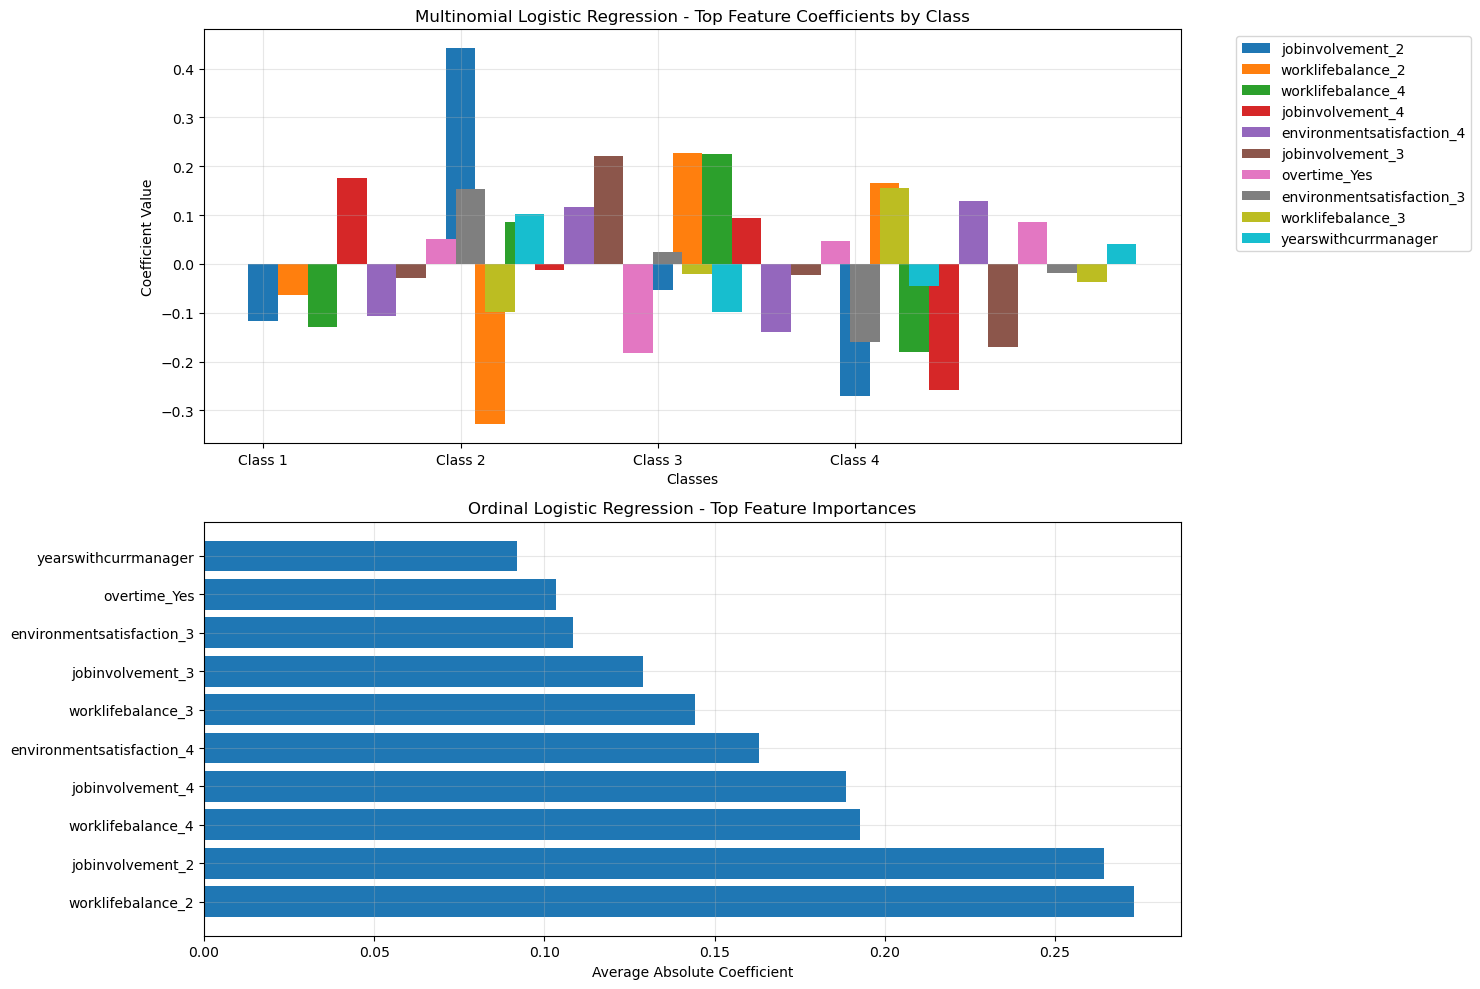


✅ All coefficients extracted and analyzed successfully!


In [26]:
# =============================================================================
# GET COEFFICIENTS FOR LOGISTIC REGRESSION MODELS
# =============================================================================
# 1. Multinomial Logistic Regression Coefficients

print("MULTINOMIAL LOGISTIC REGRESSION COEFFICIENTS")


if hasattr(multinomial_lr, 'coef_'):
    # Get the class labels
    classes = multinomial_lr.classes_
    
    # Create a DataFrame for coefficients
    coef_df_multinomial = pd.DataFrame(
        multinomial_lr.coef_,
        columns=X_train_scaled.columns,
        index=[f'Class_{cls}' for cls in classes]
    )
    
    print("Coefficients for each class (rows = classes, columns = features):")
    print(coef_df_multinomial)
    
    # Transpose for better readability (features as rows)
    print(f"\n{'='*40}")
    print("COEFFICIENTS BY FEATURE (Transposed)")
    print(f"{'='*40}")
    coef_transposed = coef_df_multinomial.T
    print(coef_transposed)
    
    # Get feature importance (average absolute coefficient across classes)
    print(f"\n{'='*40}")
    print("FEATURE IMPORTANCE (Average |Coefficient|)")
    print(f"{'='*40}")
    feature_importance = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Avg_Abs_Coefficient': np.mean(np.abs(multinomial_lr.coef_), axis=0),
        'Max_Abs_Coefficient': np.max(np.abs(multinomial_lr.coef_), axis=0)
    }).sort_values('Avg_Abs_Coefficient', ascending=False)
    
    print(feature_importance.to_string(index=False))

# 2. Ordinal Logistic Regression (One-vs-Rest) Coefficients


if hasattr(ordinal_lr, 'coef_'):
    # Get the class labels
    classes_ordinal = ordinal_lr.classes_
    
    # Create a DataFrame for coefficients
    coef_df_ordinal = pd.DataFrame(
        ordinal_lr.coef_,
        columns=X_train_scaled.columns,
        index=[f'Class_{cls}_vs_Rest' for cls in classes_ordinal]
    )
    
    print("Coefficients for each One-vs-Rest model:")
    print(coef_df_ordinal)
    
    # Also show intercepts
    print(f"\nINTERCEPTS for each One-vs-Rest model:")
    intercept_df = pd.DataFrame({
        'Class': [f'Class_{cls}_vs_Rest' for cls in classes_ordinal],
        'Intercept': ordinal_lr.intercept_
    })
    print(intercept_df.to_string(index=False))

# =============================================================================
# INTERPRET COEFFICIENTS FOR BUSINESS INSIGHTS
# =============================================================================




# For Multinomial Logistic Regression
if hasattr(multinomial_lr, 'coef_'):
    print("\n📊 MULTINOMIAL LOGISTIC REGRESSION INSIGHTS:")
    
    # Analyze each feature's impact across classes
    for feature in X_train_scaled.columns[:5]:  # Show first 5 features
        feature_coefs = multinomial_lr.coef_[:, list(X_train_scaled.columns).index(feature)]
        
        print(f"\nFeature: {feature}")
        for i, cls in enumerate(multinomial_lr.classes_):
            coef = feature_coefs[i]
            effect = "INCREASES" if coef > 0 else "DECREASES"
            print(f"  - Class {cls}: {effect} probability (coef: {coef:.4f})")
        
        # Which class is most affected by this feature?
        max_impact_class = multinomial_lr.classes_[np.argmax(np.abs(feature_coefs))]
        print(f"  → Most affected: Class {max_impact_class}")

# For Ordinal Logistic Regression
if hasattr(ordinal_lr, 'coef_'):
    print(f"\n📊 ORDINAL LOGISTIC REGRESSION INSIGHTS (One-vs-Rest):")
    
    # Since it's One-vs-Rest, coefficients show effect vs all other classes
    for feature in X_train_scaled.columns[:5]:  # Show first 5 features
        print(f"\nFeature: {feature}")
        for i, cls in enumerate(ordinal_lr.classes_):
            coef = ordinal_lr.coef_[i, list(X_train_scaled.columns).index(feature)]
            effect = "INCREASES" if coef > 0 else "DECREASES"
            print(f"  - Class {cls} vs Rest: {effect} probability (coef: {coef:.4f})")

# =============================================================================
# EXPORT COEFFICIENTS TO CSV FOR FURTHER ANALYSIS
# =============================================================================


# Export Multinomial coefficients
if hasattr(multinomial_lr, 'coef_'):
    coef_df_multinomial.to_csv('multinomial_logistic_coefficients.csv')
    print("✓ Multinomial coefficients saved to 'multinomial_logistic_coefficients.csv'")

# Export Ordinal coefficients
if hasattr(ordinal_lr, 'coef_'):
    coef_df_ordinal.to_csv('ordinal_logistic_coefficients.csv')
    print("✓ Ordinal coefficients saved to 'ordinal_logistic_coefficients.csv'")

# =============================================================================
# VISUALIZE COEFFICIENTS
# =============================================================================

# Create visualization of top coefficients
plt.figure(figsize=(15, 10))

if hasattr(multinomial_lr, 'coef_'):
    # Get top 10 features by average absolute coefficient
    top_features = feature_importance.head(10)['Feature'].values
    
    # Create subplot for multinomial coefficients
    plt.subplot(2, 1, 1)
    
    # Plot coefficients for top features across all classes
    for i, feature in enumerate(top_features):
        feature_idx = list(X_train_scaled.columns).index(feature)
        coefficients = multinomial_lr.coef_[:, feature_idx]
        plt.bar(np.arange(len(coefficients)) + i*0.15, coefficients, width=0.15, label=feature)
    
    plt.xlabel('Classes')
    plt.ylabel('Coefficient Value')
    plt.title('Multinomial Logistic Regression - Top Feature Coefficients by Class')
    plt.xticks(np.arange(len(multinomial_lr.classes_)), [f'Class {cls}' for cls in multinomial_lr.classes_])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

if hasattr(ordinal_lr, 'coef_'):
    # Create subplot for ordinal coefficients
    plt.subplot(2, 1, 2)
    
    # Plot average absolute coefficients for ordinal model
    avg_abs_coef_ordinal = np.mean(np.abs(ordinal_lr.coef_), axis=0)
    top_features_ordinal_idx = np.argsort(avg_abs_coef_ordinal)[-10:][::-1]
    top_features_ordinal = X_train_scaled.columns[top_features_ordinal_idx]
    top_coef_ordinal = avg_abs_coef_ordinal[top_features_ordinal_idx]
    
    plt.barh(range(len(top_features_ordinal)), top_coef_ordinal)
    plt.yticks(range(len(top_features_ordinal)), top_features_ordinal)
    plt.xlabel('Average Absolute Coefficient')
    plt.title('Ordinal Logistic Regression - Top Feature Importances')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ All coefficients extracted and analyzed successfully!")